## Tensorflowで"Semi-supervised Clustering for Short Text via Deep Representation Learning"の実装¶
http://aclweb.org/anthology/K16-1004



In [1]:
import tensorflow as tf
import numpy as np
import sys
import random as rd
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
from gensim.models.word2vec import Word2Vec
import MeCab
import subprocess
import itertools
import string
import sqlite3
from keras.preprocessing import sequence
rng = np.random.RandomState(1234)

Using TensorFlow backend.


# 1.データの準備

In [2]:
#
#ここで各ファイルのパスを設定します。
#

#学習に用いるデータ
dbpath = "../input/category_walkerplus.db"

#word2vecのモデル
model_path="../input/word2vec.gensim.model"

#辞書
dic_path="/usr/local/lib/mecab/dic/mecab-ipadic-neologd"

In [3]:
model = Word2Vec.load(model_path)
tagger = MeCab.Tagger("-Ochasen -d {0}".format(dic_path))

In [4]:
def cur(sourcedbname):
    con = sqlite3.connect(sourcedbname)
    cur = con.cursor()   
    sql = "select * from events"
    cur.execute(sql)
    return cur

In [5]:
Cur=cur(dbpath)

labels=[]
texts=[]
for row in Cur:
    labels.append(row[0].replace("[","").replace("]","").split(",")[1].replace(" ",""))  #Big Category
    texts.append(row[1])

## 分散表現の獲得
Data：入力の文章を分かち書きしw2vで埋め込み後padding shape=(データ数,maxlen,埋め込み次元)<br/>
Labels:正解ラベル

#### 分かち書き

In [6]:
def _tokenize(text):
    sentence = []
    node = tagger.parse(text)
    #print node
    node = node.split("\n")
    for i in range(len(node)):
        feature = node[i].split("\t")
        if feature[0] == "EOS":
            break
        hinshi = feature[3].split("-")[0]
        if "名詞" in hinshi:
            #sentence.append(feature[2].decode('utf-8'))
            sentence.append(feature[2])
        elif "形容詞" in hinshi:
            #sentence.append(feature[2].decode('utf-8'))
            sentence.append(feature[2])
        elif "動詞" in hinshi:
            #sentence.append(feature[2].decode('utf-8'))
            sentence.append(feature[2])
        elif "形容動詞" in hinshi:
            #sentence.append(feature[2].decode('utf-8'))
            sentence.append(feature[2])
        elif "連体詞" in hinshi:
            #sentence.append(feature[2].decode('utf-8'))
            sentence.append(feature[2])           
        elif "助詞" in hinshi:
            #sentence.append(feature[2].decode('utf-8'))
            sentence.append(feature[2])
            
    return sentence

### 分散表現の獲得

In [7]:
def getVector(text):
    texts = _tokenize(text)
    v = []
    for t in texts:
        if t in model.wv:
            if v == []:
                v = model.wv[t]
            else:
                v = np.vstack((v,model.wv[t]))
    if v != []:
        return v
    else:
        return np.array([])

In [8]:
Data=np.array([getVector(text) for text in texts])

/Users/tomoki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:6: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
/Users/tomoki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


In [9]:
Data = sequence.pad_sequences(Data, padding="post", truncating="post",dtype="float32")  #padding  

In [10]:
label2Label={name:i for i,name in enumerate(np.unique(labels))}  #label(名前)->Label(数字)
Labels=np.array([label2Label[label] for label in labels])  

# 2.教師データの選択

In [11]:
def load_data(Data,Labels,drop_cat,training_percent=0.9, supervise_percent=0.1):
    """
    Args:
        Data：入力の文章を分かち書きしw2vで埋め込み後padding shape=(データ数,maxlen,埋め込み次元)
        Labels:正解ラベル
        drop_cat:学習に用いないカテゴリのID
        training_percent:trainingデータに使用する割合
        supervise_percent: supervise(教師データ)として一部与える割合(training_dataに対して)
    Returns:
        train_X:Dataの学習用
        train_y:Labelsの学習用
        test_X:Dataのテスト用
        test_y:Labelsのテスト用
        supervised:学習用データにおいて一部与える教師データのindex
    """
    #trainとtestでclassが均等になるようにsplit
    cluster_num=np.unique(Labels)
    train_index = []
    
    for i in range(len(cluster_num)):
        num = Labels[Labels==i].shape[0]
        k = int(num*training_percent)
        train_index.extend(rd.sample(list(np.where(Labels==i)[0]),k))
    
    #text classification for cnn のためにあらかじめlayerを追加
    train_X = Data[train_index][:,:,:,np.newaxis]
    train_y = Labels[train_index]
    test_X = np.delete(Data,train_index,0)[:,:,:,np.newaxis]
    test_y = np.delete(Labels,train_index,0)
    
    supervised = []

    for i in range(len(cluster_num)):
        if i !=drop_cat:
            num = train_y[train_y==i].shape[0]
            k = int(num*supervise_percent)

            supervised.extend(rd.sample(list(np.where(train_y==i)[0]),k))

    
    return train_X,train_y,test_X,test_y,supervised

In [12]:
drop_cat=4

train_X,train_y,test_X,test_y, supervised = load_data(Data,Labels,drop_cat,supervise_percent=1)

In [13]:
unsupervised = list(set([i for i in range(len(train_X))])-set(supervised))

## 3.CNN for Text Classificationの実装

### HyperParams

In [22]:
#窓の幅
filter_sizes = [3,5,7]
#分散表現の次元
vector_length = train_X.shape[2]
#最大系列長
sequence_length = train_X.shape[1]
#フィルターの枚数
num_filters = 16
#隠れ層
hid_dim=100
#出力次元数
output_dim=100
#クラスタリングするクラス多数
n_cluster=len(np.unique(train_y))  #一つ教師カテゴリを隠しているが、出力は同数

alpha=0.01
l=0

In [23]:
class Conv:
    def __init__(self, sequence_length,embedding_size,filter_sizes, num_filters):
        self.sequence_length=sequence_length
        self.embedding_size=embedding_size
        self.filter_sizes=filter_sizes
        self.num_filters=num_filters
    def f_prop(self,x):
        # Create a convolution + maxpool layer for each filter size
        pooled_outputs = []
        for i, filter_size in enumerate(self.filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                # Convolution Layer
                filter_shape = [filter_size, self.embedding_size, 1, self.num_filters]
                
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[self.num_filters]), name="b")
                conv = tf.nn.conv2d(
                    x,
                    W,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
                
                # Apply nonlinearity
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                # Maxpooling over the outputs
                pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, self.sequence_length - filter_size + 1, 1, 1],
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name="pool")
                pooled_outputs.append(pooled)

        # Combine all the pooled features
        num_filters_total = num_filters * len(self.filter_sizes)
        self.h_pool = tf.concat(pooled_outputs, 3)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])
        return self.h_pool_flat

class Dense:
    def __init__(self, in_dim, out_dim, function=lambda x: x):
        # Xavier initializer
        self.W = tf.Variable(rng.uniform(
                        low=-np.sqrt(6/(in_dim + out_dim)),
                        high=np.sqrt(6/(in_dim + out_dim)),
                        size=(in_dim, out_dim)
                    ).astype('float32'), name='W')
        self.b = tf.Variable(np.zeros([out_dim]).astype('float32'))
        self.function = function

    def f_prop(self, x):
        return self.function(tf.matmul(x, self.W) + self.b)
        
class LinearDense:
    def __init__(self, in_dim, out_dim):
        # Xavier initializer
        self.W = tf.Variable(rng.uniform(
                        low=-np.sqrt(6/(in_dim + out_dim)),
                        high=np.sqrt(6/(in_dim + out_dim)),
                        size=(in_dim, out_dim)
                    ).astype('float32'), name='W')
        self.b = tf.Variable(np.zeros([out_dim]).astype('float32'))

    def f_prop(self, x):
        return tf.matmul(x, self.W) + self.b

### グラフの構築

In [24]:
input_x = tf.placeholder(tf.float32, [None, sequence_length,vector_length,1], name="input_x")
input_t = tf.placeholder(tf.float32, [None, output_dim], name="input_y")

layers = [
    Conv(sequence_length=sequence_length,
         embedding_size=vector_length,
         filter_sizes=filter_sizes,
         num_filters=num_filters),
    Dense(num_filters * len(filter_sizes),hid_dim , tf.nn.tanh),
    LinearDense(hid_dim, output_dim)
]

def f_props(layers, x):
    for i, layer in enumerate(layers):
        x = layer.f_prop(x)
    return x

pred_y = f_props(layers, input_x)


### 誤差関数の設計
<img src='../img/jsemi.png'>

In [25]:
#目的関数の定義
def _cost(pred_y, centers, neighbor_index, sup_index, mask):
    """
    Args:
        pred_y: text-cnn の出力
        centers:各ラベルごとの重心 shape=(cluster_num, output_dim)
        neighbor_index:train_Xがどの重心に最も近いか shape=(data_num,)
        sup_index:教師データとして用いるtrain_Xの対応するクラスターID index shape=(sup_num,)
        mask:教師データとして用いるindexに1、それ以外に0が入ったmask
    """
    
    term1= tf.reduce_sum(tf.square(pred_y - tf.gather(centers, neighbor_index)))    
    term1_1 = alpha*tf.cast(term1, tf.float32)
    
    
    term2 = tf.reduce_sum(mask * tf.square(pred_y - tf.nn.embedding_lookup(centers, sup_index) ))
    term2_1 = (1-alpha)*tf.cast(term2, tf.float32)

    cost = tf.add(term1_1, term2_1)
    
    for i in range(n_cluster):
        i_index = i * tf.ones_like(sup_index, dtype='int32')
        
        x1 = tf.reduce_sum(tf.square(pred_y - tf.gather(centers, sup_index)),1)#正解の重心との距離
        x2 = tf.reduce_sum(tf.square(pred_y - tf.nn.embedding_lookup(centers, i_index)),1)     #i番目の重心との距離
        x1 = tf.reshape(x1, [-1, 1])
        x2 = tf.reshape(x2, [-1, 1])
        
        term2_2 = l+x1-x2
        
        condition = tf.greater(term2_2, 0)
        term2_3 = tf.reduce_sum(mask * tf.where(condition, term2_2, tf.zeros_like(term2_2)))
        term2_3 = tf.cast(term2_3, tf.float32)

        cost=tf.add(cost, (1-alpha)*term2_3)
        
    return cost

In [26]:
#  centers:各ラベルごとの重心 shape=(cluster_num, output_dim) 
centers= tf.placeholder(tf.float32, [None, output_dim], name="centers")

#  neighbor_index:train_Xがどの重心に最も近いか shape=(data_num,)
neighbor_index= tf.placeholder(tf.int32, [None], name="neighbor_index")

#  sup_index:教師データとして用いるtrain_Xの対応するクラスターID shape=(sup_num,)
sup_index=tf.placeholder(tf.int32, [None], name="supervised_index")

#  mask:教師データとして用いるindexに1、それ以外に0が入ったmask
mask=tf.placeholder(tf.float32, [None,1], name="mask")

#自作の誤差関数
cost = _cost(pred_y, centers, neighbor_index, sup_index, mask)

# 最小化にはAdamを用いる
train = tf.train.AdamOptimizer().minimize(cost)

# 4.Iteration
<img src='../img/iter.png'>

In [31]:
def assign_to_nearest(samples, centroids,label2id):
    """
    Args:
        samples:text-cnn後の出力
        centroids:クラスターそれぞれの重心 shape=(cluster_num,output_dim)
    Returns:
        nearest: 入力データと最も近いクラスターID shape=(data_num, )
    """
    #1-1.KNearest Neighborで一番近いクラスタと紐付け
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(centroids, np.arange(len(centroids)))
    nearest = neigh.predict(samples)
    
    ###1-1.5 NEW!! ####
    from sklearn.covariance import EllipticEnvelope
    outliers_fraction = 0.05
    sup_ids =np.array([label2id[_] for _ in train_y[supervised]])
    unsup_ids = nearest[unsupervised]

    #print(label2id)
    for i in range(n_cluster):
        if i !=label2id[drop_cat]:
            print(i)
            clf=EllipticEnvelope(contamination=outliers_fraction)

            #ラベル付きデータで学習
            ind=np.where(sup_ids==i)[0]
            clf.fit(samples[supervised][ind])

            #ラベルなしデータで最近傍であっても離れすぎてないか確認
            unind=np.where(unsup_ids==i)[0]
            r = clf.predict(samples[unsupervised][unind])

            nearest[unind[r<0]]=label2id[drop_cat]

    #from scipy.stats import itemfreq
    #print(itemfreq(nearest))
    
    #################
    #1-2.ハンガリアンアルゴリズムでラベル付きデータと重心を紐付ける
    
    sup_labels =train_y[supervised]
    hglabel = np.unique(sup_labels)
    
    hgx=[]  #教師データのラベルごとに平均した点（重心）を求める
    for i in hglabel:
        ind=np.where(sup_labels==i)[0]
        hgx.append(np.mean(samples[supervised][ind], axis=0))
    hgx = np.array(hgx)

    #教師ラベルごとの重心と現在の重心との距離行列
    DistanceMatrix = np.linalg.norm(hgx[:,np.newaxis,:]-centroids[np.newaxis,:,:],axis=2)  
    
    # ハンガリアンアルゴリズムで合計が一番小さくなるように紐づける 
    from scipy.optimize import linear_sum_assignment
    row_ind, col_ind = linear_sum_assignment(DistanceMatrix)
    
    #ラベルとclusterIDを紐づける
    label2id={hglabel[i]:col for i,col in enumerate(col_ind)}
    label2id[drop_cat]=  list(set(list(range(n_cluster)))-set(label2id.values()))[0]
    
    return nearest ,label2id

In [32]:
def estimate_centroids(samples, nearest, label2id, use_supervised=True):
    """
    重心を再推定する
    重心の再推定式は簡略化してラベル付きと無しの加重平均
    Args:
        samples:text-cnn後の出力
        nearest: 入力データと最も近いクラスターID shape=(data_num, )
        label2id:labelとクラスターIDを紐づけるdict
        use_supervised:教師データを用いるかどうか（checkの際K-Meansが上手くいくか検証する際に用いいる）
    Returns:
        centroids:クラスターそれぞれの重心 shape=(cluster_num,output_dim)
        sup_cent:一部の教師データごとに現時点で対応するIDの重心が入った配列
    """
    sup_pred=samples[supervised]
    newce=np.array([label2id[t] for t in train_y[supervised]]) #現時点での一部の教師データと対応するクラスターIDの配列
            
    centroids=[]
    for i in range(n_cluster):
        sum1 = np.sum(alpha*len(np.where(nearest==i)[0]))
        sum2 = np.sum(alpha*samples[nearest==i], axis=0)
    
        if use_supervised:
            
            sum33 = np.sum((1-alpha)*len(np.where(newce==i)[0]))
            sum44 = np.sum((1-alpha)*sup_pred[newce==i], axis=0)
            
            centroids.append((sum2+sum44)/(sum1+sum33))
            
        else:
            centroids.append((sum2)/(sum1))
            
    centroids = np.array(centroids) 

    #3.NNのパラメータ更新
    sup_cent = np.array([centroids[c_id] for c_id in newce])
    
    return centroids, sup_cent



# 5.学習

In [37]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
# 学習に関するHyperParams 
max_epochs=200

nb_epoch=1 #バッチ学習一周を何回行うか
batch_size = 32
n_batches = train_X.shape[0]//batch_size


#初期値獲得
samples=sess.run(pred_y, feed_dict={input_x:train_X})
centroids = np.array(rd.sample(list(samples),n_cluster))
label2id={i:i for i in range(n_cluster)}
#Mask
mask_array = np.zeros(len(train_X), dtype=int)
mask_array[supervised] = 1        
    

for iters in range(max_epochs):
    print("Epoch : ",iters)
    savename="../output/{0:03d}".format(iters)
    
    
    samples=sess.run(pred_y, feed_dict={input_x:train_X})
    
    nearest, label2id = assign_to_nearest(samples, centroids, label2id)
    
    centroids, sup_cent = estimate_centroids(samples, nearest, label2id, use_supervised=True)
   

    newce=np.array([label2id[t] for t in train_y])  #正解ラベル->対応するクラスターIDした配列    
    

    for _ in tqdm(range(nb_epoch)):
        shuffled_train_X,  shuffled_train_y, shuffled_nearest, shuffled_newce, shuffled_mask =shuffle(train_X,train_y, nearest, newce,mask_array)
       
        for i in range(n_batches):  
            start = i * batch_size
            end = start + batch_size

            batch_X = shuffled_train_X[start:end]
            batch_y = shuffled_train_y[start:end]
            batch_nearest = shuffled_nearest[start:end]
            batch_newce   = shuffled_newce[start:end]
            batch_mask     = shuffled_mask[start:end].reshape(-1,1)
            
            sess.run(train, feed_dict={input_x:batch_X, centers : centroids, neighbor_index:batch_nearest, sup_index:batch_newce, mask:batch_mask })
    
    # クラスタリング結果(近傍ごとに色分け)
    plot_clusters(samples, centroids, train_y, save=False, save_name=savename, iter_num=iters)

    
    #収束を確認
    if iters>0:
        if np.all(nearest== prev_nearest):
                break
        else:
                from sklearn.metrics import accuracy_score
                print(accuracy_score(nearest, prev_nearest))
                prev_nearest = nearest
    else:
                prev_nearest = nearest

Epoch :  0
0
1
2
3
5


100%|██████████| 1/1 [00:04<00:00,  4.26s/it]


Epoch :  1
0
1
3
4
5


100%|██████████| 1/1 [00:04<00:00,  4.05s/it]


0.316293929712
Epoch :  2
0
1
3
4
5


100%|██████████| 1/1 [00:04<00:00,  4.04s/it]


0.721645367412
Epoch :  3
0
1
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


0.761182108626
Epoch :  4
0
1
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.75s/it]


0.773162939297
Epoch :  5
0
1
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.70s/it]


0.79392971246
Epoch :  6
0
1
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.66s/it]


0.658945686901
Epoch :  7
0
1
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.85s/it]


0.654952076677
Epoch :  8
0
1
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


0.577875399361
Epoch :  9
0
1
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.63s/it]


0.604233226837
Epoch :  10
0
1
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.71s/it]


0.619009584665
Epoch :  11
0
1
2
3
4


100%|██████████| 1/1 [00:03<00:00,  3.77s/it]


0.57947284345
Epoch :  12
0
1
2
3
4


100%|██████████| 1/1 [00:03<00:00,  3.63s/it]


0.479233226837
Epoch :  13
0
1
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


0.435702875399
Epoch :  14
0
1
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.76s/it]


0.50678913738
Epoch :  15
0
1
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.72s/it]


0.517571884984
Epoch :  16
0
1


/Users/tomoki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:613: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.75s/it]


0.384185303514
Epoch :  17
0
1
2
3
5


100%|██████████| 1/1 [00:03<00:00,  3.74s/it]


0.496805111821
Epoch :  18
0
1
2
3
5


100%|██████████| 1/1 [00:03<00:00,  3.68s/it]


0.788338658147
Epoch :  19
0
1
2
3
5


100%|██████████| 1/1 [00:03<00:00,  3.63s/it]


0.567092651757
Epoch :  20
0
1
2
4
5


100%|██████████| 1/1 [00:03<00:00,  3.78s/it]


0.506389776358
Epoch :  21
0
1
2
4
5


100%|██████████| 1/1 [00:03<00:00,  3.70s/it]


0.702076677316
Epoch :  22
1
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.67s/it]


0.601837060703
Epoch :  23
0
1
2
3
5


100%|██████████| 1/1 [00:03<00:00,  3.78s/it]


0.656948881789
Epoch :  24
0
1
2
3
5


100%|██████████| 1/1 [00:03<00:00,  3.74s/it]


0.778354632588
Epoch :  25
0
1
2
3
5


100%|██████████| 1/1 [00:03<00:00,  3.76s/it]


0.518769968051
Epoch :  26
0
1
2
4
5


100%|██████████| 1/1 [00:03<00:00,  3.66s/it]


0.717651757188
Epoch :  27
0
1
2
4
5


100%|██████████| 1/1 [00:03<00:00,  3.82s/it]


0.811900958466
Epoch :  28
1
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.66s/it]


0.798722044728
Epoch :  29
1
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.69s/it]


0.665335463259
Epoch :  30
0
1
2
4
5


100%|██████████| 1/1 [00:03<00:00,  3.74s/it]


0.819888178914
Epoch :  31
0
1
2
4
5


100%|██████████| 1/1 [00:03<00:00,  3.71s/it]


0.722444089457
Epoch :  32
0
1
2
4
5


100%|██████████| 1/1 [00:03<00:00,  3.74s/it]


0.798322683706
Epoch :  33
0
1
2
4
5


100%|██████████| 1/1 [00:03<00:00,  3.85s/it]


0.342252396166
Epoch :  34
0
1
2
3
4


100%|██████████| 1/1 [00:03<00:00,  3.84s/it]


0.262779552716
Epoch :  35
0
1
2
3
5


100%|██████████| 1/1 [00:03<00:00,  3.73s/it]


0.59624600639
Epoch :  36
0
1
2
3
5


100%|██████████| 1/1 [00:03<00:00,  3.75s/it]


0.771565495208
Epoch :  37
0
1
2
3
5


100%|██████████| 1/1 [00:03<00:00,  3.61s/it]


0.705670926518
Epoch :  38
1
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.07s/it]


0.648961661342
Epoch :  39
1
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.74s/it]


0.853833865815
Epoch :  40
1
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.69s/it]


0.880990415335
Epoch :  41
1
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.72s/it]


0.637380191693
Epoch :  42
0
1
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.79s/it]


0.523562300319
Epoch :  43
0
1
2
3
4


100%|██████████| 1/1 [00:03<00:00,  3.81s/it]


0.255591054313
Epoch :  44
0
1
2
4
5


100%|██████████| 1/1 [00:03<00:00,  3.80s/it]


0.275958466454
Epoch :  45
1
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.75s/it]


0.385782747604
Epoch :  46
0
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.73s/it]


0.246405750799
Epoch :  47
0
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.73s/it]


0.581469648562
Epoch :  48
0
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.68s/it]


0.730830670927
Epoch :  49
0
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


0.835463258786
Epoch :  50
0
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.76s/it]


0.944888178914
Epoch :  51
0
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.80s/it]


0.779153354633
Epoch :  52
0
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.67s/it]


0.85303514377
Epoch :  53
0
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.78s/it]


0.766373801917
Epoch :  54
0
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.76s/it]


0.84624600639
Epoch :  55
0
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.90s/it]


0.884584664537
Epoch :  56
0
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.78s/it]


0.781549520767
Epoch :  57
0
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.69s/it]


0.804313099042
Epoch :  58
0
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.72s/it]


0.891773162939
Epoch :  59
0
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.74s/it]


0.933306709265
Epoch :  60
0
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.83s/it]


0.876198083067
Epoch :  61
0
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.78s/it]


0.819488817891
Epoch :  62
0
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.73s/it]


0.962060702875
Epoch :  63
0
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.72s/it]


0.95607028754
Epoch :  64
0
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.66s/it]


0.919329073482
Epoch :  65
0
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.82s/it]


0.844249201278
Epoch :  66
0
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.85s/it]


0.692891373802
Epoch :  67
0
1
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.81s/it]


0.80231629393
Epoch :  68
0
1
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.73s/it]


0.153354632588
Epoch :  69
1
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.75s/it]


0.161341853035
Epoch :  70
1
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.91s/it]


0.513977635783
Epoch :  71
0
1
2
4
5


100%|██████████| 1/1 [00:03<00:00,  3.78s/it]


0.55750798722
Epoch :  72
0
1
2
4
5


100%|██████████| 1/1 [00:03<00:00,  3.71s/it]


0.348242811502
Epoch :  73
0
1
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.61s/it]


0.350239616613
Epoch :  74
0
1
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.70s/it]


0.703674121406
Epoch :  75
0
1
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.75s/it]


0.572284345048
Epoch :  76
0
1
2
3
5


100%|██████████| 1/1 [00:03<00:00,  3.82s/it]


0.301916932907
Epoch :  77
0
1
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.81s/it]


0.587460063898
Epoch :  78
0
1
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.75s/it]


0.917332268371
Epoch :  79
0
1
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.80s/it]


0.845846645367
Epoch :  80
0
1
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.75s/it]


0.820686900958
Epoch :  81
0
1
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.72s/it]


0.922523961661
Epoch :  82
0
1
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.68s/it]


0.916533546326
Epoch :  83
0
1
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.85s/it]


0.849041533546
Epoch :  84
1
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.67s/it]


0.799520766773
Epoch :  85
1
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.67s/it]


0.898562300319
Epoch :  86
1
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.73s/it]


0.948881789137
Epoch :  87
1
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.77s/it]


0.957667731629
Epoch :  88
1
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.68s/it]


0.965654952077
Epoch :  89
1
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.68s/it]


0.939297124601
Epoch :  90
1
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.74s/it]


0.939297124601
Epoch :  91
1
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.79s/it]


0.925319488818
Epoch :  92
1
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.75s/it]


0.897364217252
Epoch :  93
1
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.72s/it]


0.961261980831
Epoch :  94
1
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.68s/it]


0.975638977636
Epoch :  95
1
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.81s/it]


0.819888178914
Epoch :  96
1
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.66s/it]


0.862619808307
Epoch :  97
1
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.74s/it]


0.918130990415
Epoch :  98
1
2
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.74s/it]


0.731629392971
Epoch :  99
0
1
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.85s/it]


0.58785942492
Epoch :  100
0
1
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.76s/it]


0.460463258786
Epoch :  101
0
1
3
4
5


100%|██████████| 1/1 [00:03<00:00,  3.75s/it]


0.485623003195
Epoch :  102
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


0.546725239617
Epoch :  103
1
2
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


0.521166134185
Epoch :  104
0
1
2
4
5


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


0.628194888179
Epoch :  105
0
1
2
4
5


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


0.336661341853
Epoch :  106
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


0.67571884984
Epoch :  107
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


0.77196485623
Epoch :  108
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


0.930111821086
Epoch :  109
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


0.878594249201
Epoch :  110
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


0.914536741214
Epoch :  111
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


0.937300319489
Epoch :  112
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


0.952875399361
Epoch :  113
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


0.938498402556
Epoch :  114
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


0.836661341853
Epoch :  115
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


0.949680511182
Epoch :  116
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


0.948083067093
Epoch :  117
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


0.936900958466
Epoch :  118
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


0.961261980831
Epoch :  119
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


0.951277955272
Epoch :  120
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


0.950878594249
Epoch :  121
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


0.941693290735
Epoch :  122
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


0.922923322684
Epoch :  123
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


0.919728434505
Epoch :  124
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


0.892971246006
Epoch :  125
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


0.939696485623
Epoch :  126
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


0.971645367412
Epoch :  127
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


0.980431309904
Epoch :  128
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.72s/it]


0.849840255591
Epoch :  129
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


0.788738019169
Epoch :  130
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


0.920926517572
Epoch :  131
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.71s/it]


0.974041533546
Epoch :  132
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


0.974440894569
Epoch :  133
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


0.972843450479
Epoch :  134
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


0.96285942492
Epoch :  135
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


0.88178913738
Epoch :  136
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


0.902555910543
Epoch :  137
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


0.873402555911
Epoch :  138
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


0.401757188498
Epoch :  139
0
1
2
4
5


100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


0.467252396166
Epoch :  140
0
1
2
4
5


100%|██████████| 1/1 [00:02<00:00,  2.94s/it]


0.615015974441
Epoch :  141
1
2
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


0.498801916933
Epoch :  142
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


0.798722044728
Epoch :  143
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


0.850638977636
Epoch :  144
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


0.908546325879
Epoch :  145
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


0.942891373802
Epoch :  146
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


0.941293929712
Epoch :  147
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


0.852635782748
Epoch :  148
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


0.829872204473
Epoch :  149
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


0.974041533546
Epoch :  150
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


0.982028753994
Epoch :  151
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


0.950878594249
Epoch :  152
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


0.957268370607
Epoch :  153
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


0.955271565495
Epoch :  154
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


0.968450479233
Epoch :  155
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


0.984025559105
Epoch :  156
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


0.980031948882
Epoch :  157
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


0.979632587859
Epoch :  158
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


0.974840255591
Epoch :  159
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


0.982428115016
Epoch :  160
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


0.986022364217
Epoch :  161
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


0.980031948882
Epoch :  162
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


0.990015974441
Epoch :  163
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


0.987220447284
Epoch :  164
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


0.982028753994
Epoch :  165
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


0.982428115016
Epoch :  166
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


0.964856230032
Epoch :  167
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


0.981629392971
Epoch :  168
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


0.976038338658
Epoch :  169
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


0.983626198083
Epoch :  170
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


0.871405750799
Epoch :  171
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


0.88338658147
Epoch :  172
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


0.946086261981
Epoch :  173
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


0.958466453674
Epoch :  174
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


0.983226837061
Epoch :  175
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


0.98482428115
Epoch :  176
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


0.938498402556
Epoch :  177
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


0.946884984026
Epoch :  178
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


0.951277955272
Epoch :  179
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


0.944089456869
Epoch :  180
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


0.925319488818
Epoch :  181
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


0.864217252396
Epoch :  182
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


0.313897763578
Epoch :  183
0
1
2
3
5


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


0.231230031949
Epoch :  184
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


0.522364217252
Epoch :  185
0
1
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


0.353833865815
Epoch :  186
1
2
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


0.524361022364
Epoch :  187
1
2
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


0.810303514377
Epoch :  188
1
2
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


0.910942492013
Epoch :  189
1
2
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


0.762380191693
Epoch :  190
1
2
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


0.914536741214
Epoch :  191
1
2
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


0.942092651757
Epoch :  192
1
2
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


0.892571884984
Epoch :  193
1
2
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


0.977635782748
Epoch :  194
1
2
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


0.98642172524
Epoch :  195
1
2
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


0.986821086262
Epoch :  196
1
2
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


0.984424920128
Epoch :  197
1
2
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


0.99161341853
Epoch :  198
1
2
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


0.98642172524
Epoch :  199
1
2
3
4
5


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]

0.982428115016


In [39]:
def plot_clusters(all_samples, centroids, indices, save=False,save_name='output.png',iter_num=-1):
    
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE
    all_samples= TSNE(n_components=2, random_state=0).fit_transform(all_samples)

    #Plot out the different clusters
    #Choose a different colour for each cluster
    colour = plt.cm.rainbow(np.linspace(0,1,len(centroids)))
    
    for i, centroid in enumerate(centroids):
        #Grab just the samples fpr the given cluster and plot them out with a new colour
        samples = all_samples[indices==i]
        plt.scatter(samples[:,0], samples[:,1], c=colour[i])
        #Also plot centroid
        plt.plot(centroid[0], centroid[1], markersize=10, marker="x", color='k', mew=1)
        plt.plot(centroid[0], centroid[1], markersize=10, marker="x", color='m', mew=5)
        
        if iter_num>-1:
            plt.title('Iter : {}'.format(iter_num))
    
    if save:
        plt.savefig( save_name )
    else:
        plt.show()
    plt.close()

[4 4 4 ..., 1 1 1]


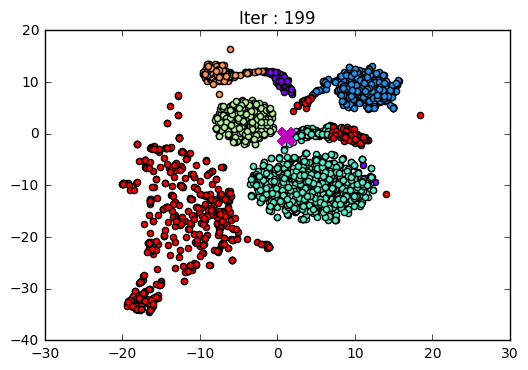

In [40]:
# クラスタリング結果(近傍ごとに色分け)
 #1-1.KNearest Neighborで一番近いクラスタと紐付け
_samples=sess.run(pred_y, feed_dict={input_x:train_X})  
_neigh = KNeighborsClassifier(n_neighbors=1)
_neigh.fit(centroids, np.arange(len(centroids)))
_nearest = _neigh.predict(_samples)
print(_nearest)
plot_clusters(_samples, centroids, _nearest,save=False, save_name=savename, iter_num=iters)

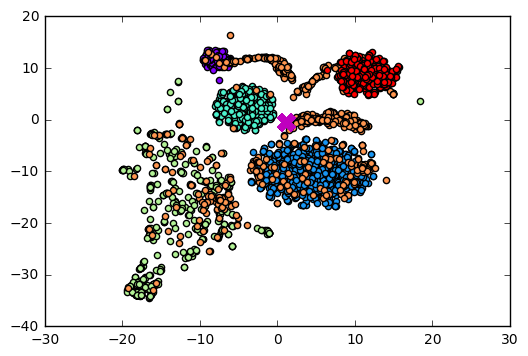

In [43]:
# クラスタリング結果（正解ラベルごとに色分け）
plot_clusters(_samples, centroids,train_y)

## 正解率評価(近傍と写像後の対応するID)

In [44]:
print(accuracy_score(nearest, np.array([label2id[_] for _ in train_y])))

0.754392971246


In [2]:
#accuracy_score(np.array([_label2id[_] for _ in train_y[train_y==drop_cat]]), nearest[train_y==drop_cat])

from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(np.array([_label2id[_] for _ in train_y[train_y==drop_cat]]), nearest[train_y==drop_cat], average='weighted')


NameError: name 'np' is not defined

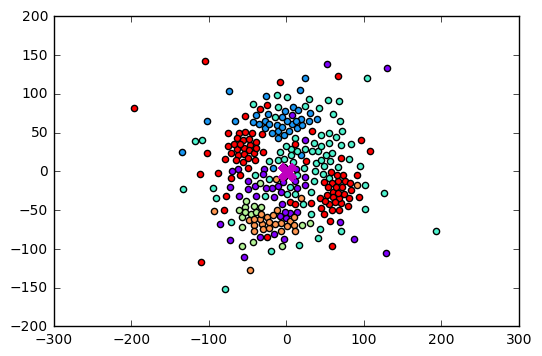

In [45]:
_samples=sess.run(pred_y, feed_dict={input_x:test_X})
    

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(centroids, np.arange(len(centroids)))
_nearest = neigh.predict(_samples)

# クラスタリング結果（正解ラベルごとに色分け）
plot_clusters(_samples, centroids, _nearest)

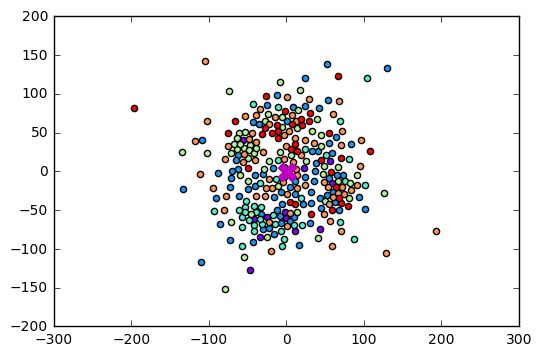

In [46]:
# クラスタリング結果（正解ラベルごとに色分け）
plot_clusters(_samples, centroids, test_y)

set

In [83]:
list(set(list(range(n_cluster)))-set(label2id.values()))[0]

2